Satellite Image URL: https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0e472180da3edf2bc72b4f38dc411dc2-a5eb37e9da677ebe2ba274218dad04f5:getPixels


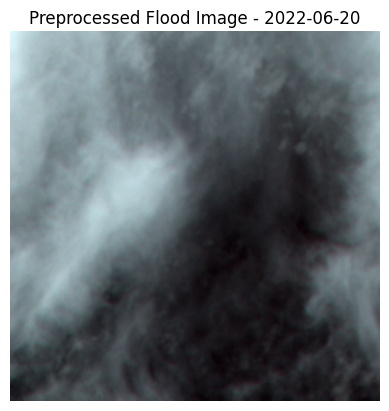

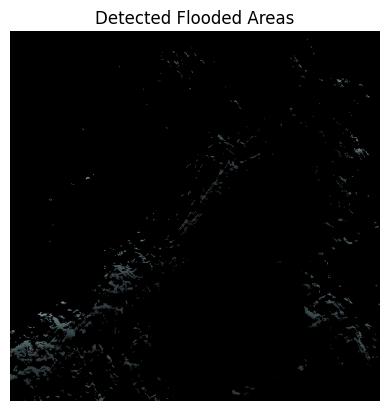

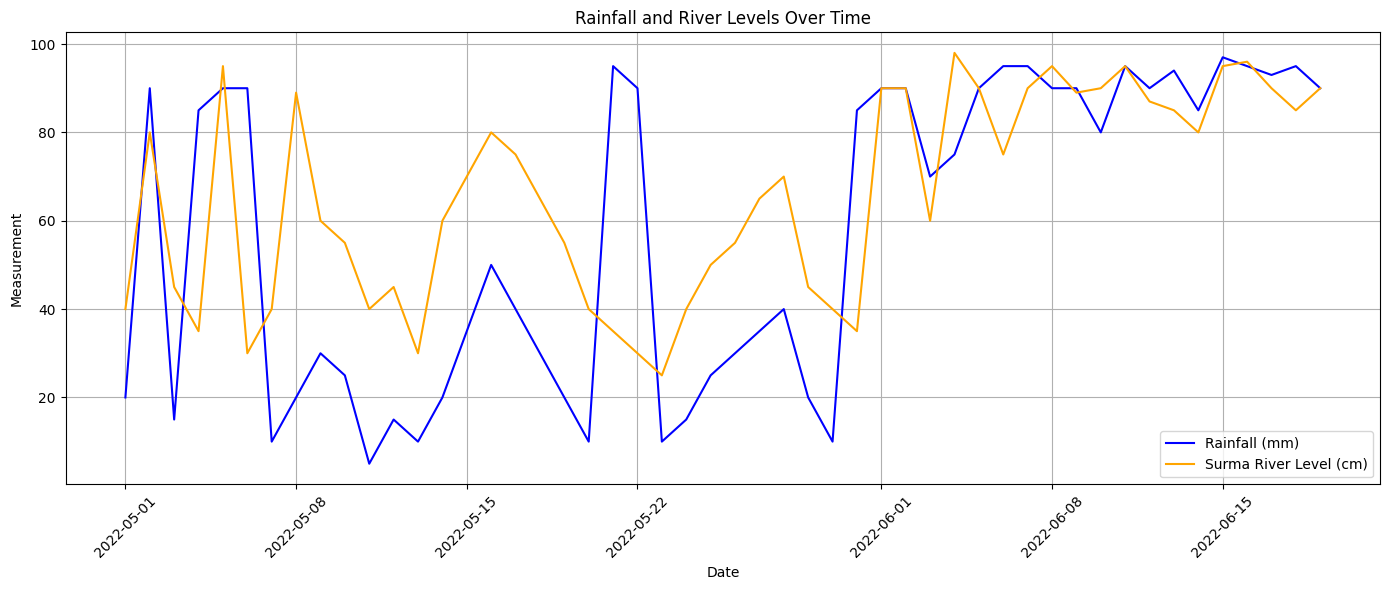

Model Accuracy: 0.8
Confusion Matrix:
[[3 0]
 [2 5]]


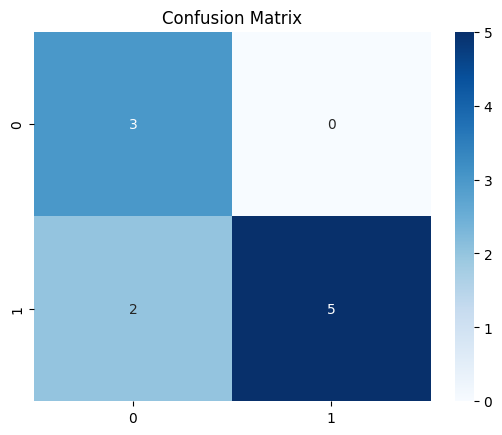

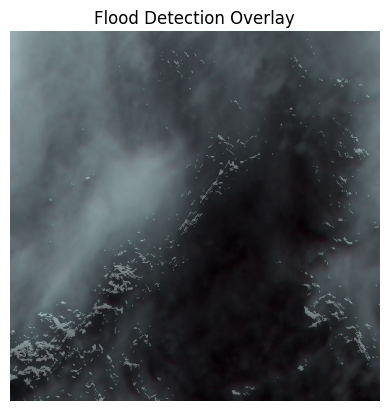

Estimated Chance of Flooding: 50.00%


In [ ]:
# Floods

import requests
import json
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from google.colab import files

# uploaded = files.upload()
df = pd.read_csv('/content/flood.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', dayfirst=True)

NASA_API_KEY = '2gq990VUavPLf9uQqDBEdKR3XpTDqDxlPCekpaGr'
longitude = 91.88
latitude = 24.89
date = '2022-06-20'
dim = 0.1
url = "https://api.nasa.gov/planetary/earth/assets"
params = {
    'lon': longitude,
    'lat': latitude,
    'date': date,
    'dim': dim,
    'api_key': NASA_API_KEY
}

response = requests.get(url, params=params)
if response.status_code == 200:
    data = response.json()
    image_url = data.get('url')
    if image_url:
        print("Satellite Image URL:", image_url)
        try:
            image_response = requests.get(image_url)
            image_response.raise_for_status()
            image = Image.open(BytesIO(image_response.content))
            image = np.array(image)
            image_resized = cv2.resize(image, (512, 512))
            image_blurred = cv2.GaussianBlur(image_resized, (5, 5), 0)
            image_normalized = cv2.normalize(image_blurred, None, 0, 255, cv2.NORM_MINMAX)
            plt.imshow(cv2.cvtColor(image_normalized, cv2.COLOR_BGR2RGB))
            plt.title(f"Preprocessed Flood Image - {date}")
            plt.axis('off')
            plt.show()
            hsv_image = cv2.cvtColor(image_normalized, cv2.COLOR_BGR2HSV)
            lower_blue = np.array([90, 50, 50])
            upper_blue = np.array([130, 255, 255])
            flood_mask = cv2.inRange(hsv_image, lower_blue, upper_blue)
            flood_result = cv2.bitwise_and(image_normalized, image_normalized, mask=flood_mask)
            plt.imshow(cv2.cvtColor(flood_result, cv2.COLOR_BGR2RGB))
            plt.title('Detected Flooded Areas')
            plt.axis('off')
            plt.show()
            plt.figure(figsize=(14, 6))
            plt.plot(pd.to_datetime(df['Date']), df['Rainfall (mm)'], label='Rainfall (mm)', color='blue')
            plt.plot(pd.to_datetime(df['Date']), df['Surma River Level(cm above danger line)'], label='Surma River Level (cm)', color='orange')
            plt.title('Rainfall and River Levels Over Time')
            plt.xlabel('Date')
            plt.ylabel('Measurement')
            plt.legend()
            plt.grid()
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
            df = pd.get_dummies(df, columns=['Soil Moisture Condition'], drop_first=True)
            df['Flood'] = np.where((df['Rainfall (mm)'] > 60) | (df['Surma River Level(cm above danger line)'] > 60), 1, 0)
            X = df[['Rainfall (mm)', 'Surma River Level(cm above danger line)'] + list(df.columns[df.columns.str.contains('Soil Moisture Condition_')])]
            y = df['Flood']
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            model = RandomForestClassifier(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            print('Model Accuracy:', accuracy)
            cm = confusion_matrix(y_test, y_pred)
            print('Confusion Matrix:')
            print(cm)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title('Confusion Matrix')
            plt.show()
            overlay = cv2.addWeighted(image_normalized, 0.7, cv2.cvtColor(flood_mask, cv2.COLOR_GRAY2BGR), 0.3, 0)
            plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
            plt.title('Flood Detection Overlay')
            plt.axis('off')
            plt.show()
            flood_chance = model.predict(X_test)
            flood_chance_percentage = np.mean(flood_chance) * 100
            print(f"Estimated Chance of Flooding: {flood_chance_percentage:.2f}%")
        except Exception as e:
            print(f"Error displaying the image: {e}")
    else:
        print("No image available for the given location and date.")
else:
    print(f"Failed to fetch data from NASA API. Status code: {response.status_code}")


Hurricane Satellite Image URL: https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5de2674643382219fded708af9386600-4197c18d0999053d6e5b571a143a89b2:getPixels


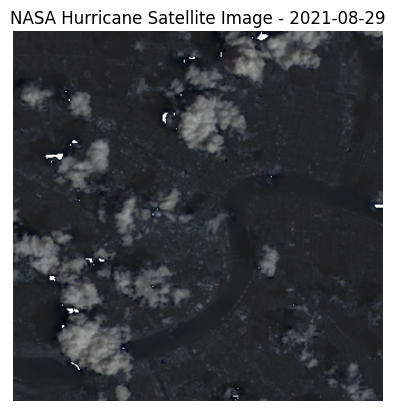

Hurricane Prediction Model Accuracy: 1.0
Hurricane Confusion Matrix:
[[3 0]
 [0 8]]


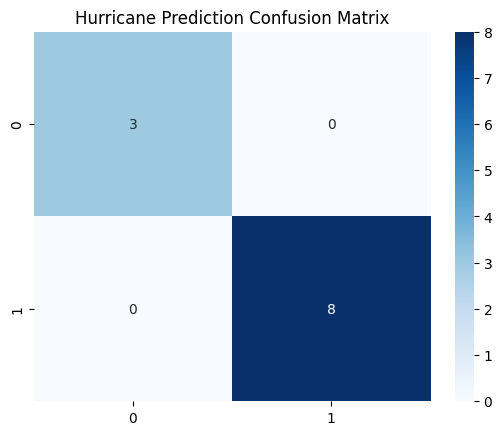

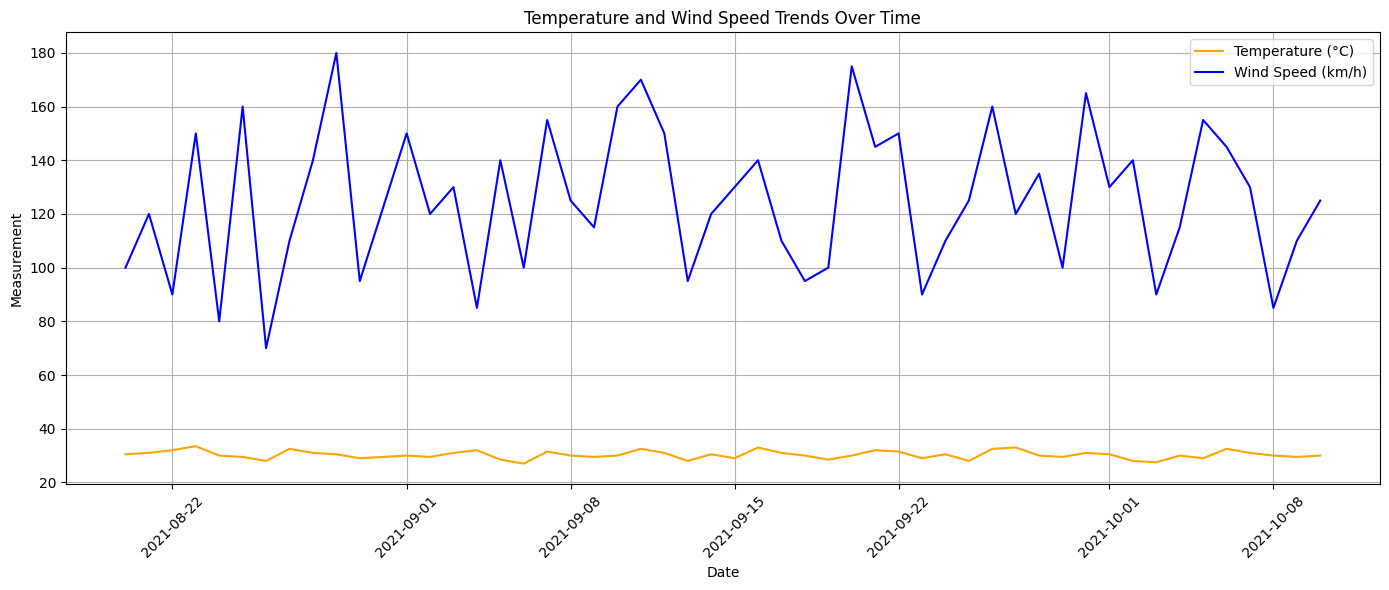

Estimated Chance of Hurricane Occurring: 72.73%


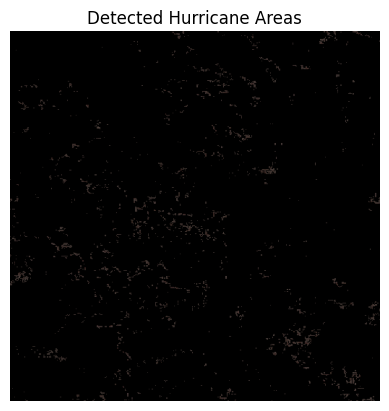

In [ ]:
# Hurricane
import requests
import json
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import cv2

NASA_API_KEY = '2gq990VUavPLf9uQqDBEdKR3XpTDqDxlPCekpaGr'

from google.colab import files
# uploaded = files.upload()
df = pd.read_csv('hurricane.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Real hurricane event: Hurricane Ida, Louisiana (August 2021)
longitude = -90.07
latitude = 29.95
date = '2021-08-29'
dim = 0.1

url = "https://api.nasa.gov/planetary/earth/assets"
params = {
    'lon': longitude,
    'lat': latitude,
    'date': date,
    'dim': dim,
    'api_key': NASA_API_KEY
}

response = requests.get(url, params=params)
if response.status_code == 200:
    data = response.json()
    image_url = data.get('url')

    if image_url:
        print("Hurricane Satellite Image URL:", image_url)
        try:
            image_response = requests.get(image_url)
            image_response.raise_for_status()
            image = Image.open(BytesIO(image_response.content))
            image_resized = cv2.resize(np.array(image), (512, 512))
            plt.imshow(image)
            plt.title(f"NASA Hurricane Satellite Image - {date}")
            plt.axis('off')
            plt.show()
            df['Hurricane'] = np.where(df['Wind Speed (km/h)'] > 120, 1, 0)
            X = df[['Temperature (°C)', 'Humidity (%)', 'Wind Speed (km/h)']]
            y = df['Hurricane']
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            model = RandomForestClassifier(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            print('Hurricane Prediction Model Accuracy:', accuracy)
            cm = confusion_matrix(y_test, y_pred)
            print('Hurricane Confusion Matrix:')
            print(cm)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title('Hurricane Prediction Confusion Matrix')
            plt.show()
            plt.figure(figsize=(14, 6))
            plt.plot(df['Date'], df['Temperature (°C)'], label='Temperature (°C)', color='orange')
            plt.plot(df['Date'], df['Wind Speed (km/h)'], label='Wind Speed (km/h)', color='blue')
            plt.title('Temperature and Wind Speed Trends Over Time')
            plt.xlabel('Date')
            plt.ylabel('Measurement')
            plt.legend()
            plt.grid()
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
            hurricane_chance = model.predict(X_test)
            hurricane_chance_percentage = np.mean(hurricane_chance) * 100
            print(f"Estimated Chance of Hurricane Occurring: {hurricane_chance_percentage:.2f}%")
            hsv_image = cv2.cvtColor(image_resized, cv2.COLOR_BGR2HSV)
            lower_hurricane = np.array([0, 50, 50])
            upper_hurricane = np.array([10, 255, 255])
            hurricane_mask = cv2.inRange(hsv_image, lower_hurricane, upper_hurricane)
            hurricane_result = cv2.bitwise_and(image_resized, image_resized, mask=hurricane_mask)
            plt.imshow(cv2.cvtColor(hurricane_result, cv2.COLOR_BGR2RGB))
            plt.title('Detected Hurricane Areas')
            plt.axis('off')
            plt.show()


        except Exception as e:
            print(f"Error processing hurricane image: {e}")
    else:
        print("No hurricane image available for the given location and date.")
else:
    print(f"Failed to fetch hurricane data from NASA API. Status code: {response.status_code}")


Index(['Date', 'Temperature', 'Wind Speed', 'Humidity', 'Wildfire'], dtype='object')
Wildfire Satellite Image URL: https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5b09df7195a2aa2b6bdcf775f7c2f1e7-dd823b586847c3619114977e76abea38:getPixels


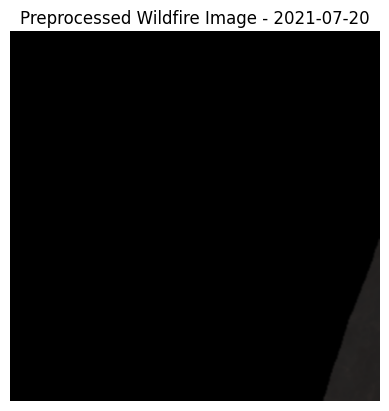

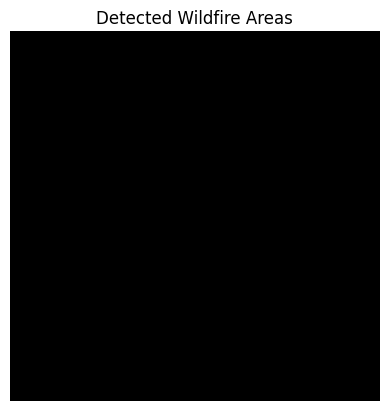

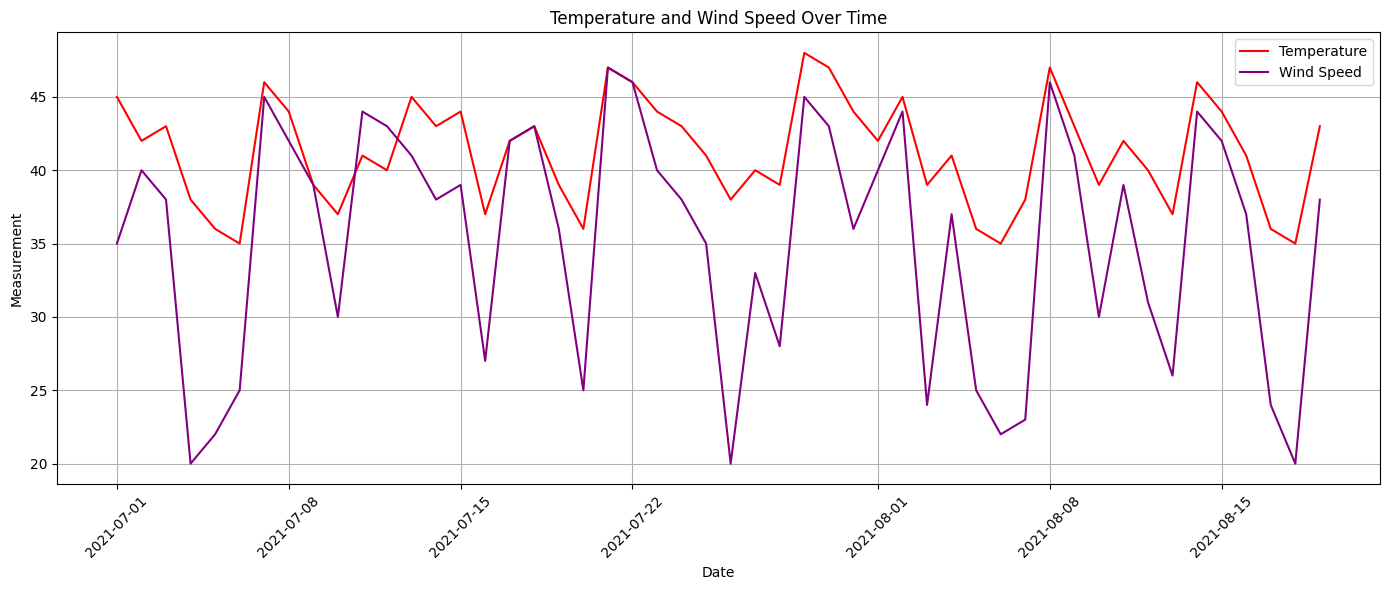

Model Accuracy: 0.9
Confusion Matrix:
[[3 0]
 [1 6]]


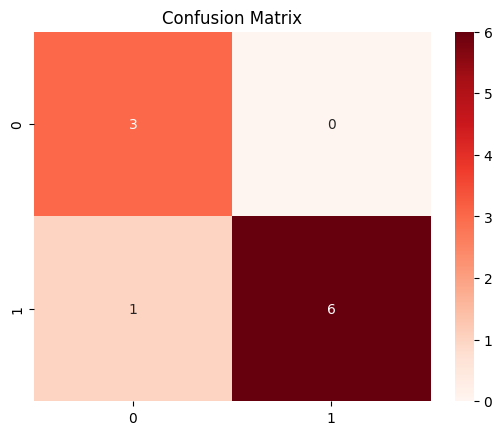

Estimated Chance of Wildfire: 60.00%


In [ ]:
# Wildfires
import requests
import json
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from google.colab import files
# uploaded=files.upload()
df = pd.read_csv('wildfire.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', dayfirst=True)
print(df.columns)
NASA_API_KEY = '2gq990VUavPLf9uQqDBEdKR3XpTDqDxlPCekpaGr'
longitude = -121.0041
latitude = 39.8226
date = '2021-07-20'
dim = 0.1
url = "https://api.nasa.gov/planetary/earth/assets"
params = {
    'lon': longitude,
    'lat': latitude,
    'date': date,
    'dim': dim,
    'api_key': NASA_API_KEY
}

response = requests.get(url, params=params)
if response.status_code == 200:
    data = response.json()
    image_url = data.get('url')
    if image_url:
        print("Wildfire Satellite Image URL:", image_url)

        try:
            image_response = requests.get(image_url)
            image_response.raise_for_status()
            image = Image.open(BytesIO(image_response.content))
            image = np.array(image)
            image_resized = cv2.resize(image, (512, 512))
            image_blurred = cv2.GaussianBlur(image_resized, (5, 5), 0)
            image_normalized = cv2.normalize(image_blurred, None, 0, 255, cv2.NORM_MINMAX)
            plt.imshow(cv2.cvtColor(image_normalized, cv2.COLOR_BGR2RGB))
            plt.title(f"Preprocessed Wildfire Image - {date}")
            plt.axis('off')
            plt.show()
            hsv_image = cv2.cvtColor(image_normalized, cv2.COLOR_BGR2HSV)
            lower_red = np.array([0, 50, 50])
            upper_red = np.array([10, 255, 255])
            fire_mask = cv2.inRange(hsv_image, lower_red, upper_red)
            fire_result = cv2.bitwise_and(image_normalized, image_normalized, mask=fire_mask)
            plt.imshow(cv2.cvtColor(fire_result, cv2.COLOR_BGR2RGB))
            plt.title('Detected Wildfire Areas')
            plt.axis('off')
            plt.show()
            plt.figure(figsize=(14, 6))
            plt.plot(pd.to_datetime(df['Date']), df['Temperature'], label='Temperature', color='red')
            plt.plot(pd.to_datetime(df['Date']), df['Wind Speed'], label='Wind Speed', color='purple')
            plt.title('Temperature and Wind Speed Over Time')
            plt.xlabel('Date')
            plt.ylabel('Measurement')
            plt.legend()
            plt.grid()
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
            X = df[['Temperature', 'Wind Speed', 'Humidity']]
            y = df['Wildfire']
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            model = RandomForestClassifier(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            print('Model Accuracy:', accuracy)
            cm = confusion_matrix(y_test, y_pred)
            print('Confusion Matrix:')
            print(cm)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
            plt.title('Confusion Matrix')
            plt.show()
            wildfire_chance = model.predict(X_test)
            wildfire_chance_percentage = np.mean(wildfire_chance) * 100
            print(f"Estimated Chance of Wildfire: {wildfire_chance_percentage:.2f}%")

        except Exception as e:
            print(f"Error displaying the image: {e}")
    else:
        print("No image available for the given location and date.")
else:
    print(f"Failed to fetch data from NASA API. Status code: {response.status_code}")


Earthquake Satellite Image URL: https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2c98be85515e59acc4e196cbd966d057-8e28630a5e9f29d4d7870a191769f5d4:getPixels


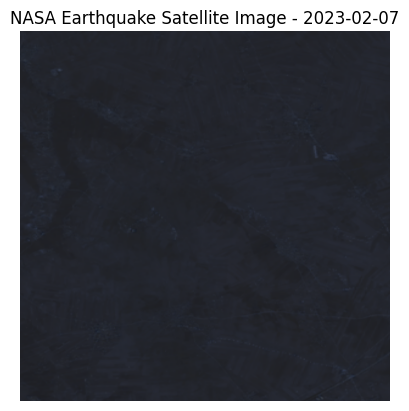

Earthquake Prediction Model Accuracy: 1.0
Earthquake Confusion Matrix:
[[3 0]
 [0 8]]


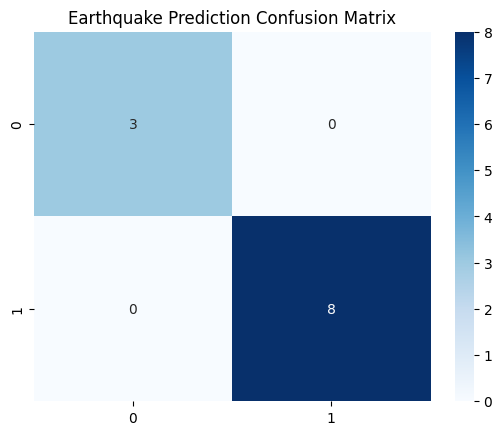

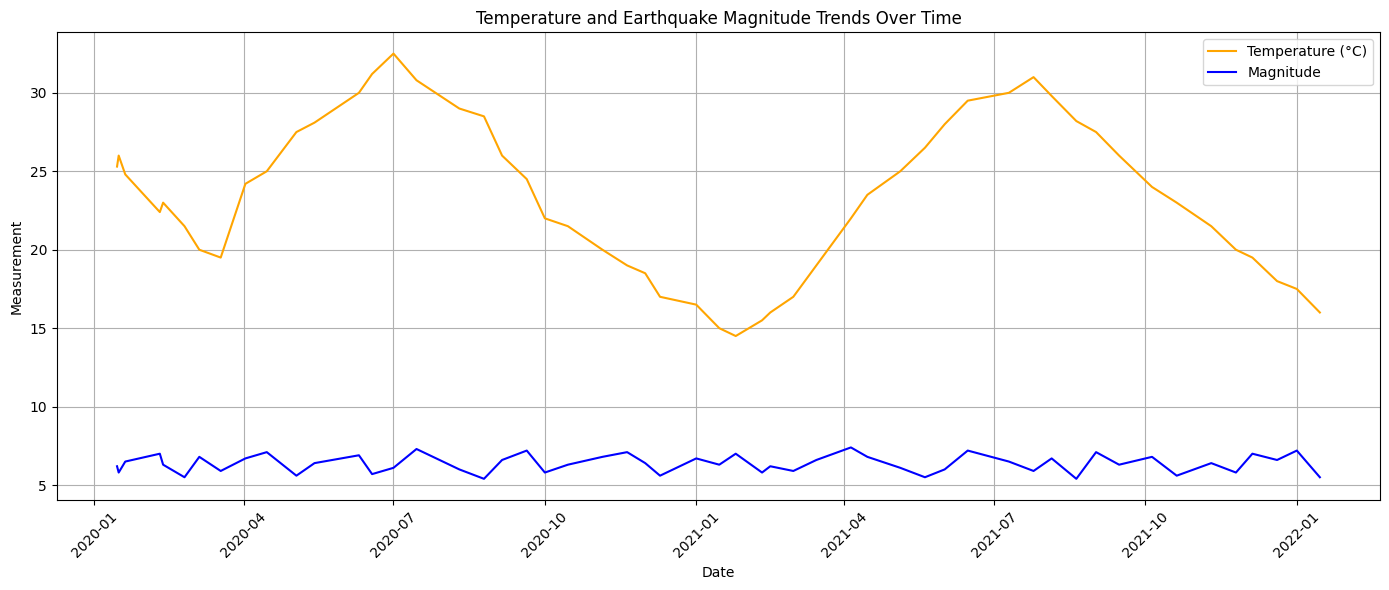

Estimated Chance of Earthquake Occurring: 72.73%


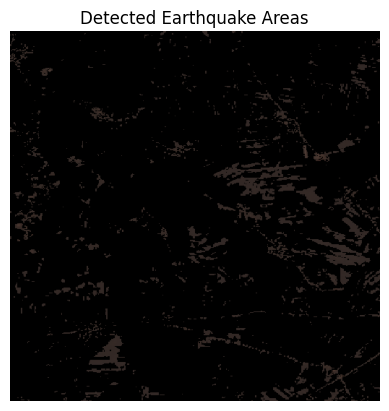

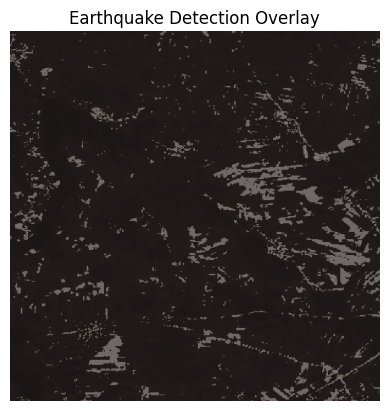

In [ ]:
# Earthquake
import requests
import json
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import cv2

NASA_API_KEY = '2gq990VUavPLf9uQqDBEdKR3XpTDqDxlPCekpaGr'
from google.colab import files
# uploaded = files.upload()
df = pd.read_csv('earthquake.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Real earthquake event: Turkey-Syria Earthquake (February 2023)
longitude = 37.66
latitude = 36.50
date = '2023-02-07'
dim = 0.1

url = "https://api.nasa.gov/planetary/earth/assets"
params = {
    'lon': longitude,
    'lat': latitude,
    'date': date,
    'dim': dim,
    'api_key': NASA_API_KEY
}
response = requests.get(url, params=params)
if response.status_code == 200:
    data = response.json()
    image_url = data.get('url')

    if image_url:
        print("Earthquake Satellite Image URL:", image_url)
        try:
            image_response = requests.get(image_url)
            image_response.raise_for_status()
            image = Image.open(BytesIO(image_response.content))
            image_resized = cv2.resize(np.array(image), (512, 512))
            plt.imshow(image)
            plt.title(f"NASA Earthquake Satellite Image - {date}")
            plt.axis('off')
            plt.show()
            df['Earthquake'] = np.where(df['Magnitude'] > 6.0, 1, 0)
            X = df[['Temperature (°C)', 'Humidity (%)', 'Magnitude']]
            y = df['Earthquake']
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            model = RandomForestClassifier(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            print('Earthquake Prediction Model Accuracy:', accuracy)
            cm = confusion_matrix(y_test, y_pred)
            print('Earthquake Confusion Matrix:')
            print(cm)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title('Earthquake Prediction Confusion Matrix')
            plt.show()
            plt.figure(figsize=(14, 6))
            plt.plot(df['Date'], df['Temperature (°C)'], label='Temperature (°C)', color='orange')
            plt.plot(df['Date'], df['Magnitude'], label='Magnitude', color='blue')
            plt.title('Temperature and Earthquake Magnitude Trends Over Time')
            plt.xlabel('Date')
            plt.ylabel('Measurement')
            plt.legend()
            plt.grid()
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
            earthquake_chance = model.predict(X_test)
            earthquake_chance_percentage = np.mean(earthquake_chance) * 100
            print(f"Estimated Chance of Earthquake Occurring: {earthquake_chance_percentage:.2f}%")
            hsv_image = cv2.cvtColor(image_resized, cv2.COLOR_BGR2HSV)
            lower_earthquake = np.array([0, 50, 50])
            upper_earthquake = np.array([10, 255, 255])
            earthquake_mask = cv2.inRange(hsv_image, lower_earthquake, upper_earthquake)
            earthquake_result = cv2.bitwise_and(image_resized, image_resized, mask=earthquake_mask)
            plt.imshow(cv2.cvtColor(earthquake_result, cv2.COLOR_BGR2RGB))
            plt.title('Detected Earthquake Areas')
            plt.axis('off')
            plt.show()
            overlay_mask = np.where(earthquake_mask > 0, 1, 0).astype(np.uint8)
            overlay = cv2.addWeighted(image_resized, 0.7, cv2.cvtColor(overlay_mask * 255, cv2.COLOR_GRAY2BGR), 0.3, 0)
            plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
            plt.title('Earthquake Detection Overlay')
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"Error processing earthquake image: {e}")
    else:
        print("No earthquake image available for the given location and date.")
else:
    print(f"Failed to fetch earthquake data from NASA API. Status code: {response.status_code}")

